<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [4]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

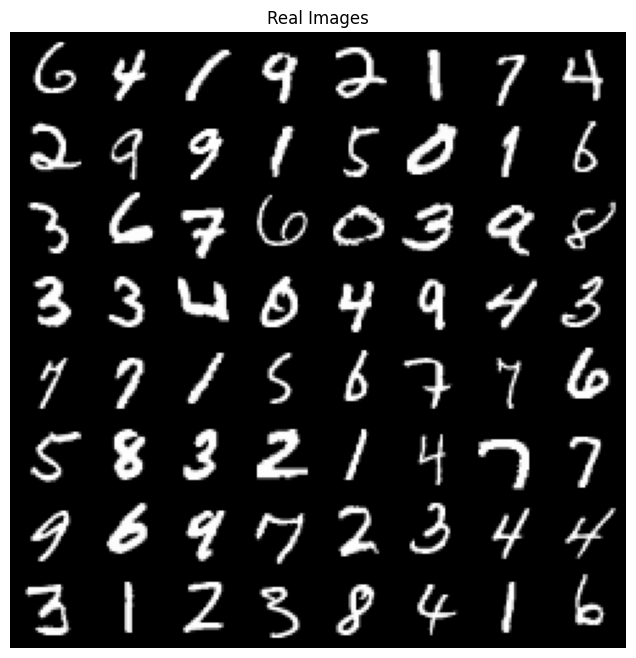

In [5]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

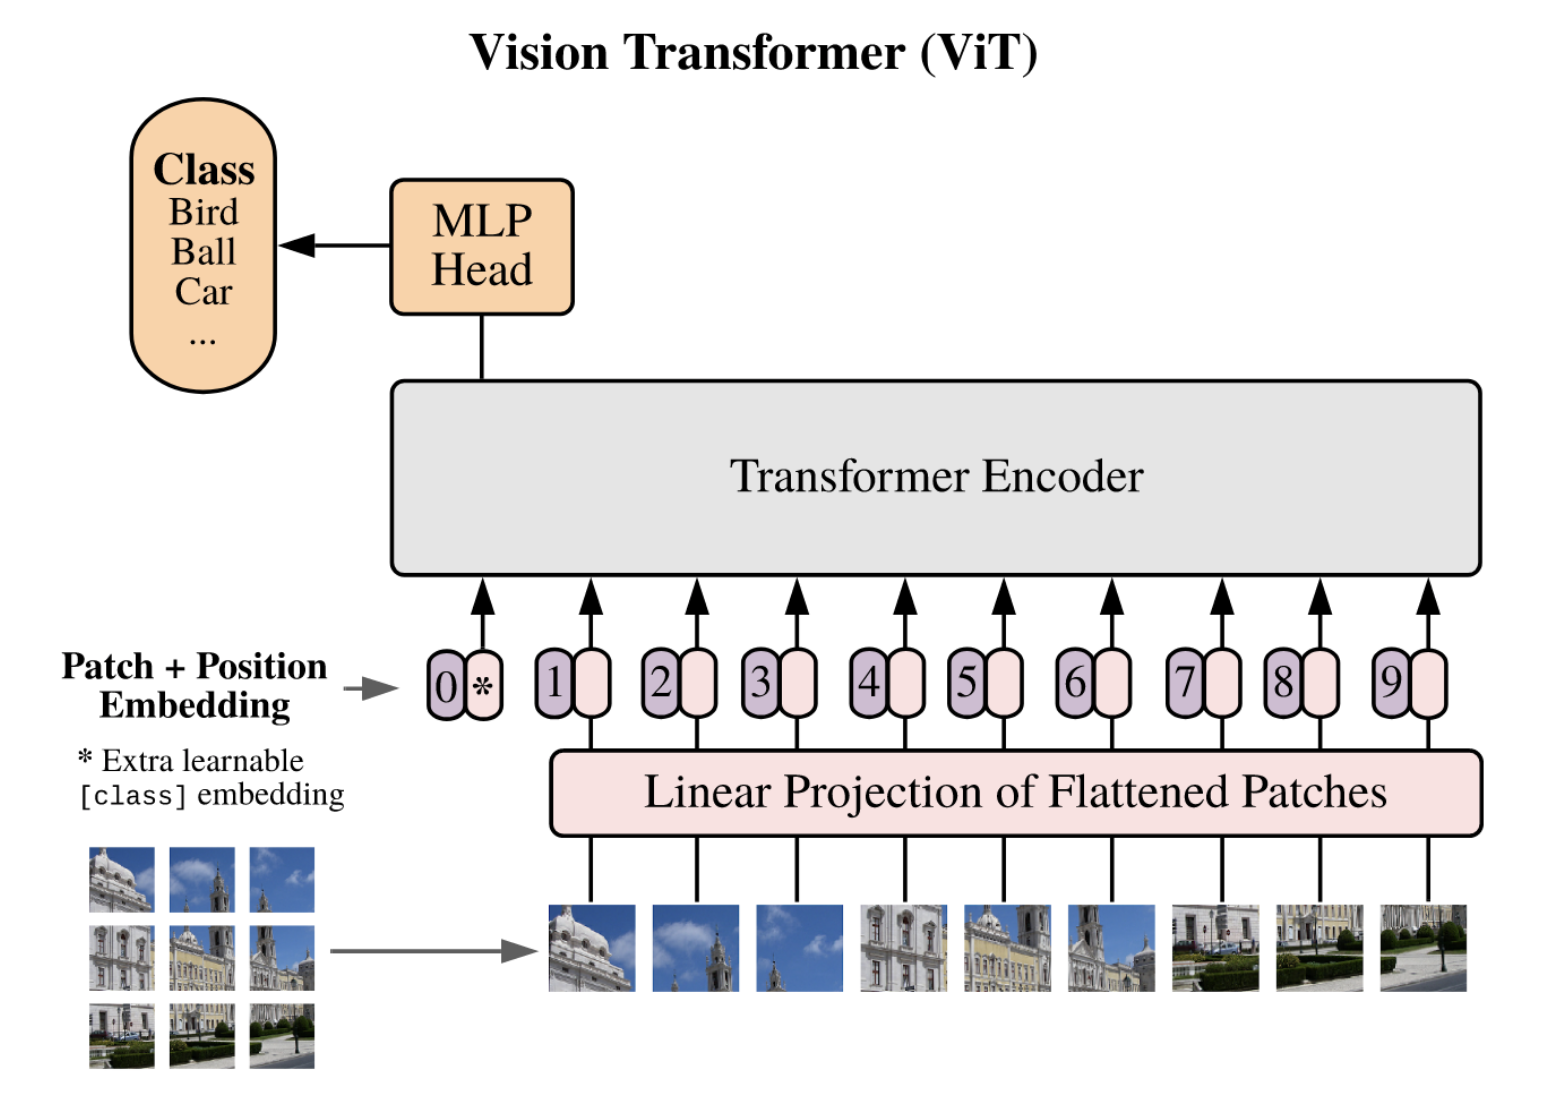

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [6]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
      super().__init__()
      self.projection = nn.Conv2d(in_channels=in_chan, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
      x = self.projection(x)

      B, C, H, W = x.shape

      x = x.view(B, -1, C)

      # x.shape() -> B, N, C
      return x


In [7]:
patch_embedder = PatchEmbed(in_chan=3, patch_size=16, embed_dim=128)

batch_size = 32
image_channels = 3
image_height = 128
image_width = 128

random_data = torch.randn(batch_size, image_channels, image_height, image_width)

output = patch_embedder(random_data)

print("Forme du tenseur de sortie :", output.shape)

Forme du tenseur de sortie : torch.Size([32, 64, 128])


# Transformer encoder

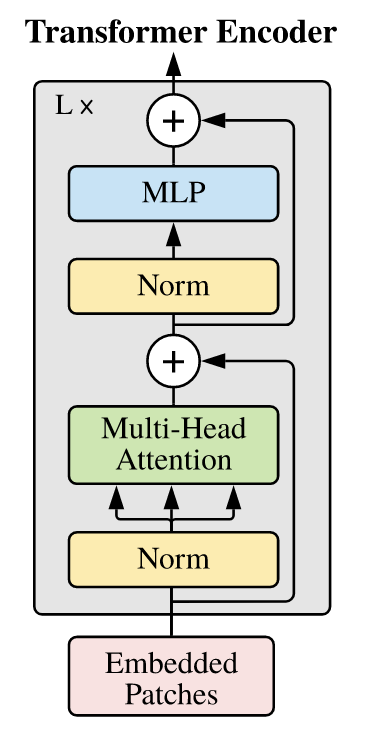

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [8]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features))


    def forward(self, x):
        return self.seq(x)

MLP(128, 512)(torch.randn(32, 16, 128)).shape


torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [9]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim

        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        self.projection = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        B, N, C = x.shape

        # Projection des Q, K et V
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Calcul de la matrice d'attention en utilisant Q et K
        attention = torch.matmul(q, k.transpose(-2, -1))
        attention = attention / (self.embed_dim ** 0.5)

        attention = F.softmax(attention, dim=-1)

        x = torch.matmul(attention, v)

        return self.projection(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [10]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
        B, N, C = x.shape

        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        # Divisez en plusieurs têtes
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)


        # Calculez l'attention par produit scalaire pour chaque tête
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2))
        attention_scores = attention_scores * self.scale
        attention_probs = F.softmax(attention_scores, dim=-1)

        head_outputs = torch.matmul(attention_probs, v)

        # Fusionnez les têtes
        head_outputs = head_outputs.permute(0, 2, 1, 3).contiguous().view(B, N, C)

        # Projection linéaire pour l'output
        output = self.projection(head_outputs)

        return output



MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

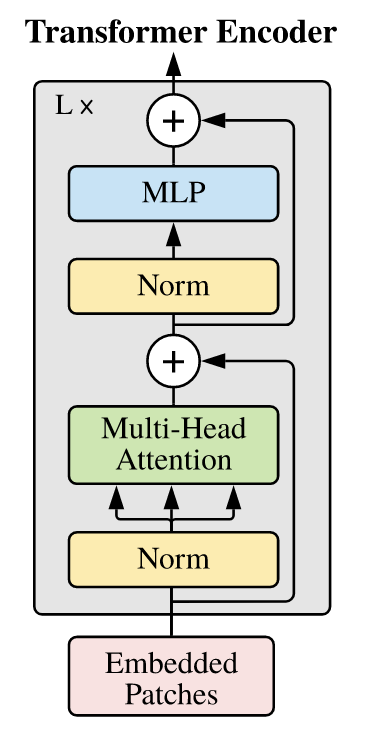

In [11]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.self_attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.norm = nn.LayerNorm(embed_dim)

    hidden_dim = embed_dim * mlp_ratio
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    output = self.norm(x)
    output = self.self_attention(output)
    tmp = x + output
    output = self.norm(tmp)

    output = self.mlp(output)

    return tmp + output


Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [12]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim))
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)

    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    ## image to patches
    x = self.patch_embed(x)

    ## concatenating class token
    B, N, C = x.shape
    class_tokens = self.class_token.expand(B, 1, C)
    x = torch.cat((class_tokens, x), dim=1)

    ## adding positional embedding
    x = x + self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = self.norm(x)

    ## classification output
    class_output = x[:, 0, :]
    output = self.head(class_output)
    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  losses = 0
  n = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    loss = F.cross_entropy(yhat, y)
    losses += loss.item()
    n += 1

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2), round(losses/n, 2)

And run! Feel free to try other hyperparameters.

In [37]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc, _ = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


--- Epoch 0 ---
Train loss: 0.6016087813545138
--- Epoch 1 ---
Train loss: 0.17627792565553174
--- Epoch 2 ---
Train loss: 0.13293658551186133
--- Epoch 3 ---
Train loss: 0.10969229977427007
--- Epoch 4 ---
Train loss: 0.09588767052777032
--- Epoch 5 ---
Train loss: 0.08564800616385522
--- Epoch 6 ---
Train loss: 0.07621402136767025
--- Epoch 7 ---
Train loss: 0.07112093553987583
--- Epoch 8 ---
Train loss: 0.06264212226439546
--- Epoch 9 ---
Train loss: 0.05719556107815268
Test accuracy: 97.51


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [45]:
def plot_param_variatino(param_values, param_name, train_accs_param, train_losses_param, test_accs_param, test_losses_param):
  plt.figure(figsize=(15,10))

  plt.subplot(221)
  for i in range(len(param_values)):
    plt.plot(range(epochs),train_accs_param[i],label=param_values[i])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

  plt.title(f"Train_Accuracy - {param_name}")
  plt.legend()

  plt.subplot(222)
  for i in range(len(param_values)):
    plt.plot(range(epochs),train_losses_param[i],label=param_values[i])
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

  plt.title(f"Train_Loss - {param_name}")
  plt.legend()

  plt.subplot(223)
  for i in range(len(param_values)):
    plt.plot(range(epochs),test_accs_param[i],label=param_values[i])
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")

  plt.title(f"Test_Accuracy - {param_name}")
  plt.legend()

  plt.subplot(224)
  for i in range(len(param_values)):
    plt.plot(range(epochs),test_losses_param[i],label=param_values[i])
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

  plt.title(f"Test_Loss - {param_name}")
  plt.legend()

  plt.suptitle(f"Variation of {param_name}")
  plt.show()

--- Embded : 8 ---
	--- Epoch 0 ---
	Train loss: 1.4458502864024279
	--- Epoch 9 ---
	Train loss: 0.28418128402121284


--- Embded : 16 ---
	--- Epoch 0 ---
	Train loss: 0.800709096766484
	--- Epoch 9 ---
	Train loss: 0.11199858986429059


--- Embded : 32 ---
	--- Epoch 0 ---
	Train loss: 0.6139386768248289
	--- Epoch 9 ---
	Train loss: 0.0548987901940354


--- Embded : 64 ---
	--- Epoch 0 ---
	Train loss: 0.48955281201138423
	--- Epoch 9 ---
	Train loss: 0.03662880178047483




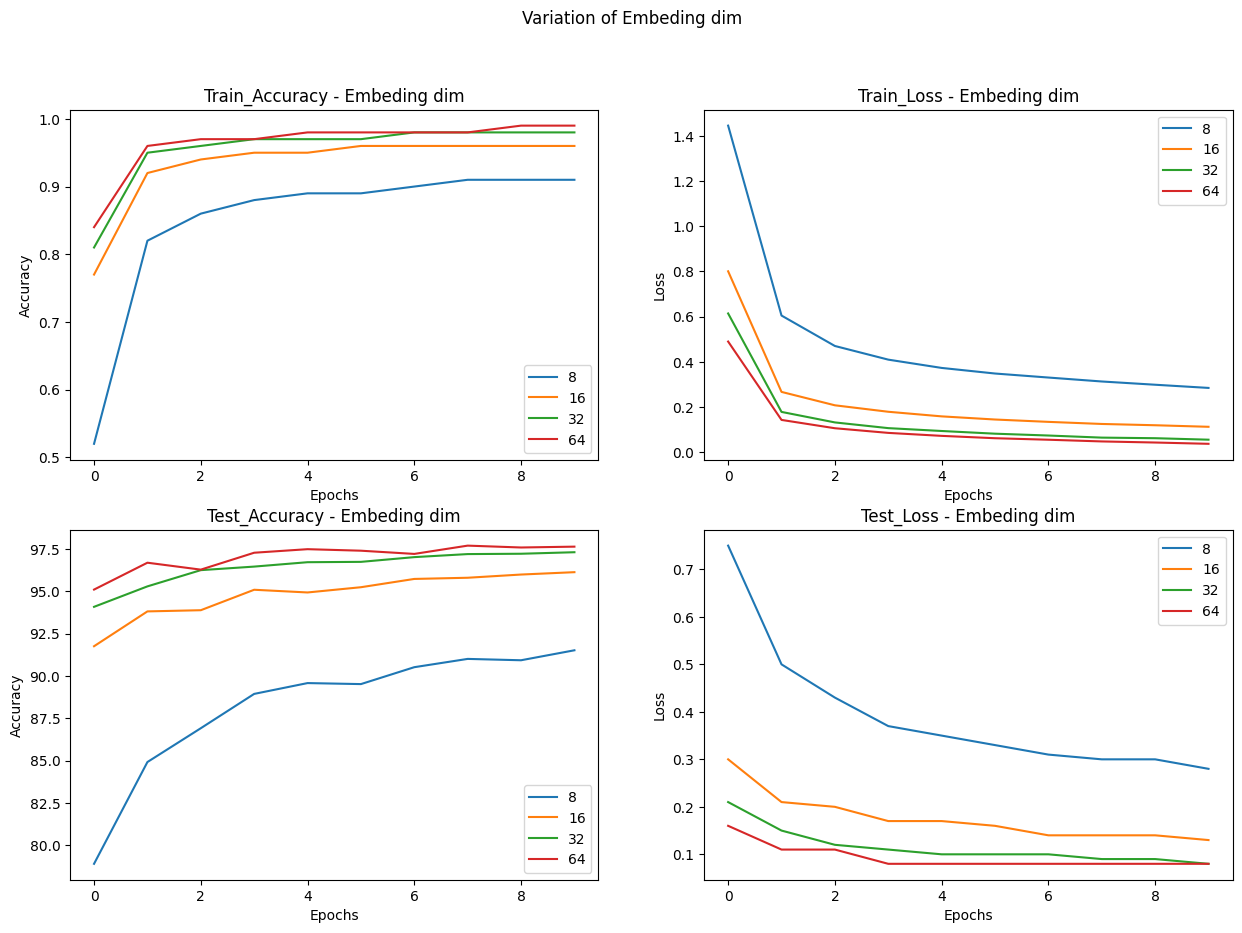

In [46]:
epochs = 10

patch_size = 7
nb_blocks = 2
embed_dim = 32

train_losses_param = []
train_accs_param = []
test_losses_param = []
test_accs_param = []

emdedings = [8, 16, 32, 64]
for embed_dim in emdedings:

  print(f"--- Embded : {embed_dim} ---")
  train_losses_model = []
  train_accs_model = []
  test_losses_model = []
  test_accs_model = []

  model = ViT(embed_dim, nb_blocks, patch_size).cuda()
  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0

    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    if epoch == 0 or epoch == epochs - 1:
      print(f"\t--- Epoch {epoch} ---")
      print(f"\tTrain loss: {train_loss / len(train_loader)}")

    train_losses_model.append(train_loss / len(train_loader))
    train_accs_model.append(round(acc/c, 2))

    test_acc, test_loss = eval_model(model, test_loader)
    test_losses_model.append(test_loss)
    test_accs_model.append(test_acc)

  print("\n")

  train_losses_param.append(train_losses_model)
  train_accs_param.append(train_accs_model)
  test_losses_param.append(test_losses_model)
  test_accs_param.append(test_accs_model)

plot_param_variatino(emdedings, "Embeding dim", train_accs_param, train_losses_param, test_accs_param, test_losses_param)

--- Nb Blocks : 2 ---
	--- Epoch 0 ---
	Train loss: 0.6009405415290708
	--- Epoch 9 ---
	Train loss: 0.05665404560552763


--- Nb Blocks : 4 ---
	--- Epoch 0 ---
	Train loss: 0.584417974977478
	--- Epoch 9 ---
	Train loss: 0.04503798344657063


--- Nb Blocks : 6 ---
	--- Epoch 0 ---
	Train loss: 0.5653695195817998
	--- Epoch 9 ---
	Train loss: 0.040645111269796134


--- Nb Blocks : 8 ---
	--- Epoch 0 ---
	Train loss: 0.6158901393445316
	--- Epoch 9 ---
	Train loss: 0.04569116703866086




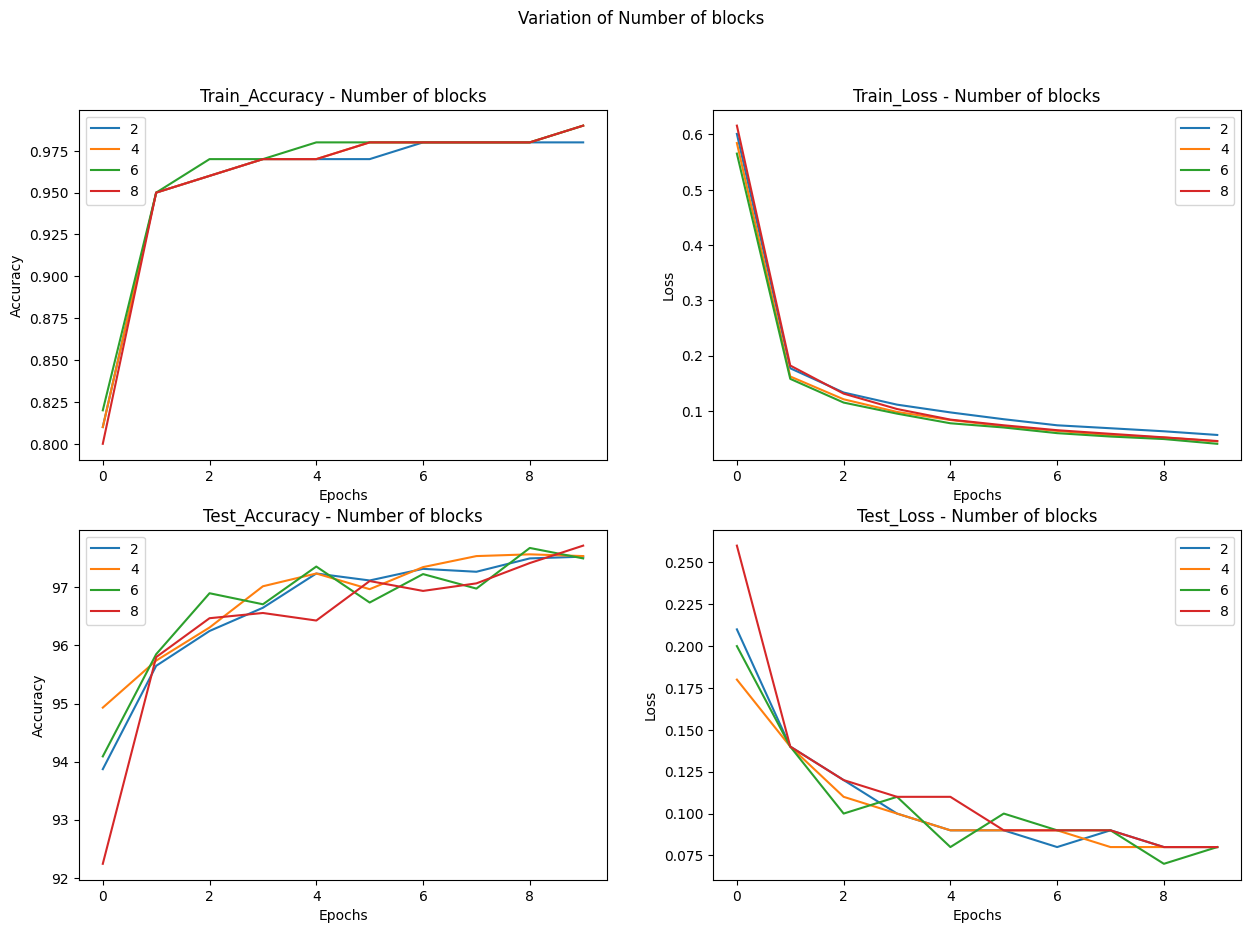

In [51]:
epochs = 10

patch_size = 7
nb_blocks = 2
embed_dim = 32

train_losses_param = []
train_accs_param = []
test_losses_param = []
test_accs_param = []

nbblocks = [2, 4, 6, 8]
for nb_blocks in nbblocks:

  print(f"--- Nb Blocks : {nb_blocks} ---")
  train_losses_model = []
  train_accs_model = []
  test_losses_model = []
  test_accs_model = []

  model = ViT(embed_dim, nb_blocks, patch_size).cuda()
  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0

    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    if epoch == 0 or epoch == epochs - 1:
      print(f"\t--- Epoch {epoch} ---")
      print(f"\tTrain loss: {train_loss / len(train_loader)}")

    train_losses_model.append(train_loss / len(train_loader))
    train_accs_model.append(round(acc/c, 2))

    test_acc, test_loss = eval_model(model, test_loader)
    test_losses_model.append(test_loss)
    test_accs_model.append(test_acc)

  print("\n")

  train_losses_param.append(train_losses_model)
  train_accs_param.append(train_accs_model)
  test_losses_param.append(test_losses_model)
  test_accs_param.append(test_accs_model)

plot_param_variatino(nbblocks, "Number of blocks", train_accs_param, train_losses_param, test_accs_param, test_losses_param)

--- Patch size : 4 ---
	--- Epoch 0 ---
	Train loss: 0.7199206135547491
	--- Epoch 9 ---
	Train loss: 0.060537050645957304


--- Patch size : 7 ---
	--- Epoch 0 ---
	Train loss: 0.6103198588498111
	--- Epoch 9 ---
	Train loss: 0.05277010841346753


--- Patch size : 11 ---
	--- Epoch 0 ---
	Train loss: 0.5461418084434863
	--- Epoch 9 ---
	Train loss: 0.055215153918623416


--- Patch size : 14 ---
	--- Epoch 0 ---
	Train loss: 0.47964194785557324
	--- Epoch 9 ---
	Train loss: 0.04003719536752414




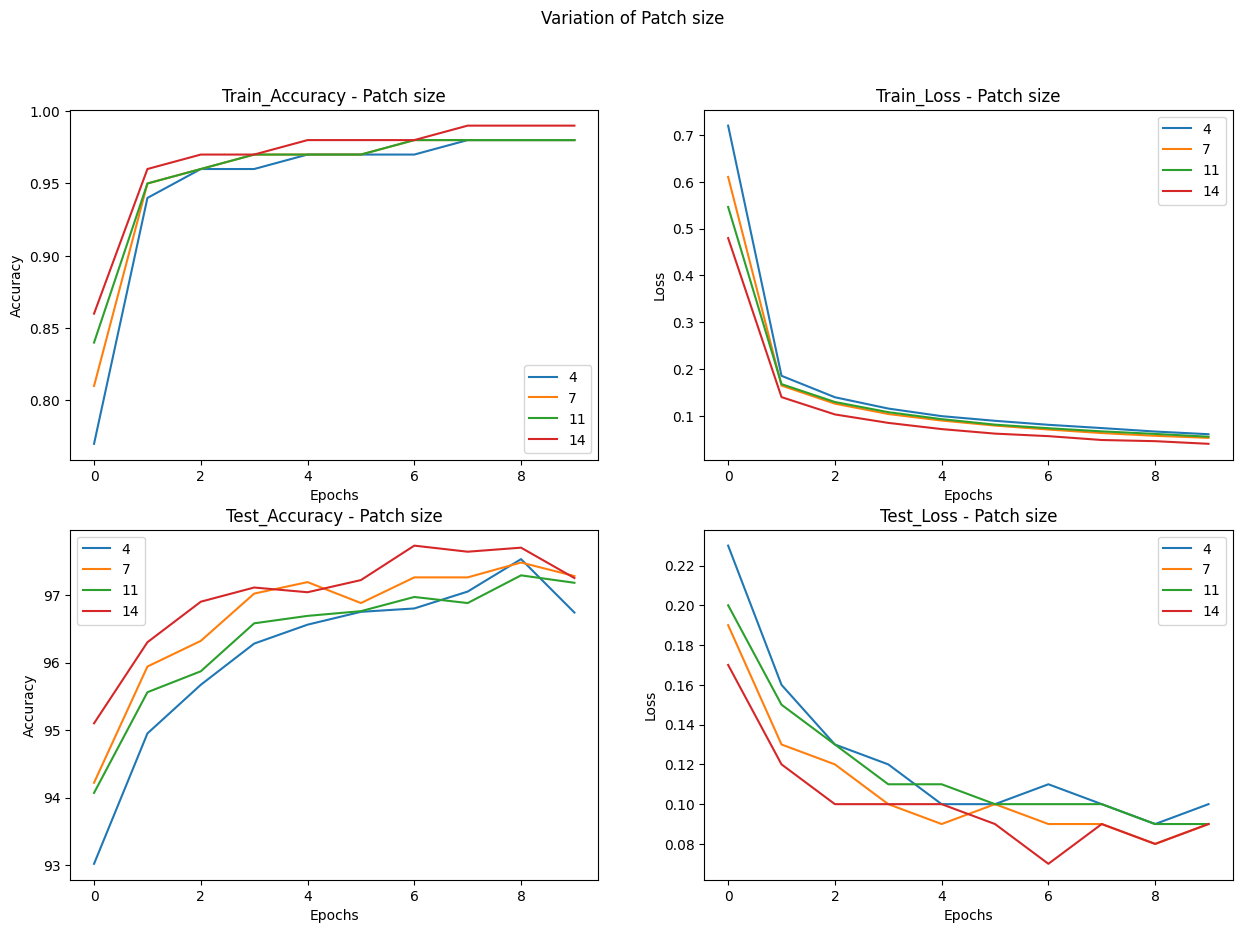

In [50]:
epochs = 10

patch_size = 7
nb_blocks = 2
embed_dim = 32

train_losses_param = []
train_accs_param = []
test_losses_param = []
test_accs_param = []

patchs = [4, 7, 11, 14]
for patch_size in patchs:
  print(f"--- Patch size : {patch_size} ---")
  train_losses_model = []
  train_accs_model = []
  test_losses_model = []
  test_accs_model = []

  model = ViT(embed_dim, nb_blocks, patch_size).cuda()
  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0

    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    if epoch == 0 or epoch == epochs - 1:
      print(f"\t--- Epoch {epoch} ---")
      print(f"\tTrain loss: {train_loss / len(train_loader)}")

    train_losses_model.append(train_loss / len(train_loader))
    train_accs_model.append(round(acc/c, 2))

    test_acc, test_loss = eval_model(model, test_loader)
    test_losses_model.append(test_loss)
    test_accs_model.append(test_acc)

  print("\n")

  train_losses_param.append(train_losses_model)
  train_accs_param.append(train_accs_model)
  test_losses_param.append(test_losses_model)
  test_accs_param.append(test_accs_model)

plot_param_variatino(patchs, "Patch size", train_accs_param, train_losses_param, test_accs_param, test_losses_param)

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [15]:
!pip install timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [16]:
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(32, 1, 28, 28))
except AssertionError as err:
    print(err)



Input height (28) doesn't match model (224).


In [23]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT

display(x.size())

torch.Size([32, 3, 28, 28])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [20]:
input_resolution = 28
num_classes = 10

# Load the pre-trained ViT model from Timm with adapted settings
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes,
    in_chans=3,
    img_size=input_resolution,
)

model(torch.randn(32, 3, 28, 28)).shape


torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [21]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [22]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1)# adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

--- Epoch 0 ---
Train loss: 1.2848942005303876
--- Epoch 1 ---
Train loss: 0.5367894138989926
--- Epoch 2 ---
Train loss: 0.4413585608829059
--- Epoch 3 ---
Train loss: 0.403896887355776
--- Epoch 4 ---
Train loss: 0.381473404130956
--- Epoch 5 ---
Train loss: 0.3618242996397303
--- Epoch 6 ---
Train loss: 0.3515213736529543
--- Epoch 7 ---
Train loss: 0.33644444592344736
--- Epoch 8 ---
Train loss: 0.32460432552071267
--- Epoch 9 ---
Train loss: 0.32706233859062195
Test accuracy: 89.11


c) redo the training but with the ViT-S pretrained on ImageNet

In [33]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [34]:
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes,
    in_chans=1,
    img_size=input_resolution,
).cuda()

In [35]:

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")


--- Epoch 0 ---
Train loss: 1.2956990090006195
--- Epoch 1 ---
Train loss: 0.5114353796058118
--- Epoch 2 ---
Train loss: 0.41559385957875483
--- Epoch 3 ---
Train loss: 0.36877067606332203
--- Epoch 4 ---
Train loss: 0.3402535597652769
--- Epoch 5 ---
Train loss: 0.3172525158727855
--- Epoch 6 ---
Train loss: 0.30717669173217277
--- Epoch 7 ---
Train loss: 0.29390710072794446
--- Epoch 8 ---
Train loss: 0.2852935054536059
--- Epoch 9 ---
Train loss: 0.2762959743422994


In [36]:
acc = eval_model(model, test_loader, num_channels=1)
print(f"Test accuracy: {acc}")

Test accuracy: 89.31
